In [2]:
from datetime import datetime as d

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math as m
np.set_printoptions(precision=4, suppress=True)

In [225]:
today = datetime.datetime(2020, 4, 25)

# Outline (As recommended by 538's 2016 Election Model)
_Link:_ https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

1) Collect, weight and average polls. 

2) Adjust polls.

3) Combine polls with demographic and (in the case of polls-plus) economic data.

4) Account for uncertainty and simulate the election thousands of times.

_Sources:_
- https://github.com/davidasiegel/Nate_Silver_Presidential_Elections
- https://github.com/jseabold/538model/blob/master/silver_model.ipynb
    - Combined this with Ben Jones’ stuff
- https://github.com/jscottusf/election-dat
- https://github.com/benjones4747/silver/tree/5841d9a76ce78330c4ef701a3cc12a9e50097fdd/lib
    - Helpful with Step 1

## Step 1: Collect, Weight, and Average the Polls

#### Polls

In [3]:
#gathers polls from 538
poll = pd.read_csv('Relevant_Data/2020/president_polls.csv')
poll.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.0
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.0
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.0


#### Calculating Weighted Average (Recency, Pollster Rating, Sample Size)

In [4]:
pollster_weights = pd.read_csv('2018_Pollster_Rating - Sheet1.csv')
pollster_weights.head(5)

,Pollster,# of Polls,NCPP / AAPOR / Roper,Exclusively Live Caller With Cellphones,Methodology,Banned by 538,Historical Advanced Plus-Minus,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect
0,Selzer & Co.,43,yes,yes,Live,no,-1.9,-1.4,A+,R +0.0,...,4.2,5.6,-1.4,-1.9,-1.1,-1.4,30,R +0.0,R +0.0,D +0.1
1,Monmouth University,95,yes,yes,Live,no,-1.5,-1.3,A+,D +1.4,...,5.3,6.2,-0.8,-1.5,-1.1,-1.3,65,D +2.1,D +1.4,R +0.7
2,Field Research Corp. (Field Poll),25,yes,yes,Live,no,-2.5,-1.1,A+,R +1.2,...,3.9,5.7,-1.8,-2.5,-1.1,-1.1,18,R +3.3,R +1.2,D +0.6
3,ABC News/Washington Post,60,yes,yes,Live,no,-1.3,-1.1,A+,D +0.6,...,2.9,4.6,-1.8,-1.3,-0.9,-1.1,55,D +0.9,D +0.6,D +1.5
4,Elway Research,21,yes,yes,Live,no,-2.2,-1.1,A+,D +0.5,...,3.9,5.9,-1.9,-2.2,-0.9,-1.1,20,D +1.2,D +0.5,D +3.2


In [5]:
#HELPER FUNCTION 
def month(value):
    return value[0]

def year(value):
    return value[-2:]

In [6]:
polls = pd.merge(poll, pollster_weights, left_on = "pollster", right_on = "Pollster")
#for i in polls.columns:
    #print(i)

In [7]:
# Recency (most recent: 4/5/20)
# Need to use exponential decay to compare the polling time to the election date
# Caveat: Being farther out from election day makes polls kind of useless
# Our code predicts if the elections were to happen on April 5th, 2020

def exp_decay(days):
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

def ageweight(raw):
    raw['age_weight'] = 0.0
    for index, row in raw.iterrows():
        d0 = ('4/5/20')
        d0 = d.strptime(d0, '%m/%d/%y')
        date = row['end_date']
        d1 = d.strptime(date, '%m/%d/%y')
        delta = d0 - d1
        diff = delta.days
        age_weight = exp_decay(diff)
        raw.at[index,'recency_weight'] = age_weight
    return

ageweight(polls)

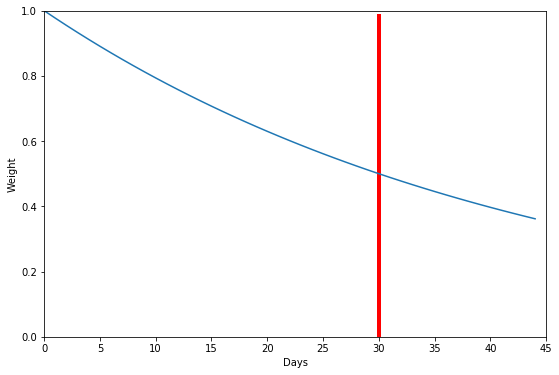

In [8]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45);

In [9]:
polls[['end_date','recency_weight']]

,end_date,recency_weight
0,4/4/20,0.977160
1,4/4/20,0.977160
2,2/18/20,0.337587
3,2/18/20,0.337587
4,2/18/20,0.337587
5,2/18/20,0.337587
6,2/18/20,0.337587
7,2/18/20,0.337587
8,2/18/20,0.337587
9,2/18/20,0.337587


In [10]:
# Pollster Rating
def weight(x):
    #i think this weight i based on the 2016 elections
    newx = float(1 - (1/(3.025044 + 1.200763)) * (x + 1.200763))
    return newx

def apply_weights(pr):
    pr['pollster_weight'] = 0.0
    for index, row in pr.iterrows():
        x = row['Predictive Plus-Minus']
        if row['Banned by 538'] == 'yes':
            newx = 0.0
        else:
            newx = weight(x)
        pr.at[index,'pollster_weight'] = newx
    return pr

In [11]:
apply_weights(polls)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
5,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
6,118577,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
7,118577,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
8,118578,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
9,118578,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506


In [12]:
# Sample size (based on how Nate Silver used it in 2008)
mean = np.mean(polls['sample_size'])
polls['sample_size_weight'] = (polls['sample_size']/mean)**2
polls[['sample_size', 'sample_size_weight']]

,sample_size,sample_size_weight
0,3244.0,4.377505
1,3244.0,4.377505
2,672.0,0.187847
3,672.0,0.187847
4,668.0,0.185617
5,668.0,0.185617
6,671.0,0.187288
7,671.0,0.187288
8,661.0,0.181747
9,661.0,0.181747


In [13]:
# Get weighted averages
polls['weighted_average'] = polls['recency_weight'] * polls['pollster_weight'] * polls['sample_size_weight']

def weighted_average(df):
    weights1 = df['recency_weight']
    weights2 = df['pollster_weight']
    weights3 = df['sample_size_weight']
    return weights1*weights2*weights3
    
polls.groupby(['state', 'pollster']).apply(weighted_average)

state      pollster                                 
Alabama    Mason-Dixon Polling & Research Inc.  2322    0.032710
                                                2323    0.032710
                                                2324    0.032710
                                                2325    0.032710
                                                2326    0.032710
                                                2327    0.032710
                                                2328    0.032710
                                                2329    0.032710
                                                2330    0.032710
                                                2331    0.032710
Alaska     Zogby Interactive/JZ Analytics       2588    0.000080
                                                2589    0.000080
                                                2590    0.000080
                                                2591    0.000080
                                     

In [14]:
polls.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.185617,0.050788


In [15]:
polls.columns

Index(['question_id', 'poll_id', 'cycle', 'state', 'pollster_id', 'pollster',
       'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id',
       'pollster_rating_name', 'fte_grade', 'sample_size', 'population',
       'population_full', 'methodology', 'office_type', 'seat_number',
       'seat_name', 'start_date', 'end_date', 'election_date',
       'sponsor_candidate', 'internal', 'partisan', 'tracking',
       'nationwide_batch', 'ranked_choice_reallocated', 'created_at', 'notes',
       'url', 'stage', 'answer', 'candidate_name', 'candidate_party', 'pct',
       'Pollster', '# of Polls', 'NCPP / AAPOR / Roper',
       'Exclusively Live Caller With Cellphones', 'Methodology',
       'Banned by 538', 'Historical Advanced Plus-Minus',
       'Predictive    Plus-Minus', '538 Grade', 'Mean-Reverted Bias',
       'Races Called Correctly', 'Misses Outside MOE', 'Simple Average Error',
       'Simple Expected Error', 'Simple Plus-Minus', 'Advanced Plus-Minus',
       'Mean-Rever

In [38]:
polls.groupby('state')['pct'].

## Step 2: Adjust polls

* Likely voter adjustment
* Convention bounce adjustment (in only the polls-plus model)
* Omitted third-party candidate adjustment
* Trend line adjustment
* House effects adjustment

In [ ]:
#Likely Voter Adjustment


In [34]:
pvi = pd.read_csv("Relevant_Data/2020/fivethirtyeight_partisan_lean_STATES copy.csv")
pvi.head()

,state,pvi_538
0,Alabama,R+27
1,Alaska,R+15
2,Arizona,R+9
3,Arkansas,R+24
4,California,D+24


In [35]:
pvi.set_index("state", inplace=True);
pvi.head()

,pvi_538
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [36]:
pvi.columns = ['PVI']
pvi.head()

,PVI
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [37]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

state
Alabama          -27.0
Alaska           -15.0
Arizona           -9.0
Arkansas         -24.0
California        24.0
Colorado           1.0
Connecticut       11.0
Delaware          14.0
Florida           -5.0
Georgia          -12.0
Hawaii            36.0
Idaho            -35.0
Illinois          13.0
Indiana          -18.0
Iowa              -6.0
Kansas           -23.0
Kentucky         -23.0
Louisiana        -17.0
Maine              5.0
Maryland          23.0
Massachusetts     29.0
Michigan           1.0
Minnesota          2.0
Mississippi      -15.0
Missouri         -19.0
Montana          -18.0
Nebraska         -24.0
Nevada            -1.0
New Hampshire     -2.0
New Jersey        13.0
New Mexico         7.0
New York          22.0
North Carolina    -5.0
North Dakota     -33.0
Ohio              -7.0
Oklahoma         -34.0
Oregon             9.0
Pennsylvania      -1.0
Rhode Island      26.0
South Carolina   -17.0
South Dakota     -31.0
Tennessee        -28.0
Texas            -17.0
Utah 

In [73]:
party_affil = pd.read_csv("party_affiliation_by_state.csv")
party_affil =party_affil.rename(columns={'Unnamed: 0': "State", 'Democrat/Lean Democratic': 'Democrat', 
                           'Republican/Lean Republican': 'Republican', 
                            'Democratic advantage':'Dem_Adv'}).set_index("State")[1:53]
party_affil

,Democrat,Republican,Dem_Adv,N,Classification
State,,,,,
U.S.,45,38,7,"180,106",Lean Dem
Maine,47,39,8,941,Lean Dem
New Hampshire,43,40,3,831,Competitive
Vermont,52,30,22,496,Solid Dem
Massachusetts,57,26,31,"3,805",Solid Dem
Rhode Island,48,27,21,602,Solid Dem
Connecticut,51,32,19,"2,020",Solid Dem
New York,52,29,23,"10,864",Solid Dem
New Jersey,48,33,15,"4,455",Solid Dem


In [74]:
party_affil.columns

Index(['Democrat', 'Republican', 'Dem_Adv', 'N', 'Classification'], dtype='object')

In [75]:
party_affil['Democrat'] = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican
party_affil

,Democrat,Republican,Dem_Adv,N,Classification,no_party
State,,,,,,
U.S.,45.0,38.0,7,"180,106",Lean Dem,17.0
Maine,47.0,39.0,8,941,Lean Dem,14.0
New Hampshire,43.0,40.0,3,831,Competitive,17.0
Vermont,52.0,30.0,22,496,Solid Dem,18.0
Massachusetts,57.0,26.0,31,"3,805",Solid Dem,17.0
Rhode Island,48.0,27.0,21,602,Solid Dem,25.0
Connecticut,51.0,32.0,19,"2,020",Solid Dem,17.0
New York,52.0,29.0,23,"10,864",Solid Dem,19.0
New Jersey,48.0,33.0,15,"4,455",Solid Dem,19.0


In [ ]:
# Census